In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score, root_mean_squared_error

In [2]:
# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
# --- Data Loading ---
# Load data from .mat file
data_path = "data/tpu_aerodynamic_database.mat"
mat_data = loadmat(data_path)

In [4]:
# Extract fields
roof_pitch = mat_data['Roof_pitch'].flatten()
roof_type = mat_data['Roof_type'].flatten()
sample_frequency = mat_data['Sample_frequency'].flatten()
building_depth = mat_data['Building_depth'].flatten()
building_breadth = mat_data['Building_breadth'].flatten()
building_height = mat_data['Building_height'].flatten()
wind_direction_angle = mat_data['Wind_direction_angle'].flatten()
wind_pressure_coefficients = mat_data['Wind_pressure_coefficients']

mean_pressure_coefficients = wind_pressure_coefficients.mean(axis=1)

In [5]:
# Ensure each feature has the same length
num_samples = mean_pressure_coefficients.shape[0]
features = pd.DataFrame({
    "Roof_pitch": np.tile(roof_pitch, num_samples // len(roof_pitch)),
    "Roof_type": np.tile(roof_type, num_samples // len(roof_type)),
    "Sample_frequency": np.tile(sample_frequency, num_samples // len(sample_frequency)),
    "Building_depth": np.tile(building_depth, num_samples // len(building_depth)),
    "Building_breadth": np.tile(building_breadth, num_samples // len(building_breadth)),
    "Building_height": np.tile(building_height, num_samples // len(building_height)),
    "Wind_direction_angle": np.tile(wind_direction_angle, num_samples // len(wind_direction_angle)),
})
features["Mean_pressure_coefficient"] = mean_pressure_coefficients


In [6]:
# One-hot encode Roof_type
feature_df = pd.get_dummies(features, columns=["Roof_type"], drop_first=True)

In [7]:
# --- Train-Test Split ---
X = feature_df.drop(columns=["Mean_pressure_coefficient"])
y = feature_df["Mean_pressure_coefficient"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [9]:
# --- XGBoost Model ---
eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)]
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=200,
                             max_depth=5,
                             learning_rate=0.1,
                             random_state=42)
xgb_model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=True)


[0]	validation_0-rmse:0.13301	validation_1-rmse:0.12802
[1]	validation_0-rmse:0.13301	validation_1-rmse:0.12802
[2]	validation_0-rmse:0.13301	validation_1-rmse:0.12802
[3]	validation_0-rmse:0.13301	validation_1-rmse:0.12802
[4]	validation_0-rmse:0.13301	validation_1-rmse:0.12802
[5]	validation_0-rmse:0.13301	validation_1-rmse:0.12802
[6]	validation_0-rmse:0.13301	validation_1-rmse:0.12802
[7]	validation_0-rmse:0.13301	validation_1-rmse:0.12802
[8]	validation_0-rmse:0.13301	validation_1-rmse:0.12802
[9]	validation_0-rmse:0.13301	validation_1-rmse:0.12802
[10]	validation_0-rmse:0.13301	validation_1-rmse:0.12802
[11]	validation_0-rmse:0.13301	validation_1-rmse:0.12802
[12]	validation_0-rmse:0.13301	validation_1-rmse:0.12802
[13]	validation_0-rmse:0.13301	validation_1-rmse:0.12802
[14]	validation_0-rmse:0.13301	validation_1-rmse:0.12802
[15]	validation_0-rmse:0.13301	validation_1-rmse:0.12802
[16]	validation_0-rmse:0.13301	validation_1-rmse:0.12802
[17]	validation_0-rmse:0.13301	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [10]:
# XGBoost evaluation
y_pred_xgb = xgb_model.predict(X_test_scaled)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - MAE: {mae_xgb:.4f}, MAPE: {mape_xgb:.4f}, MSE: {mse_xgb:.4f}, R²: {r2_xgb:.4f}")


XGBoost - MAE: 0.0972, MAPE: 0.5201, MSE: 0.0164, R²: -0.0004


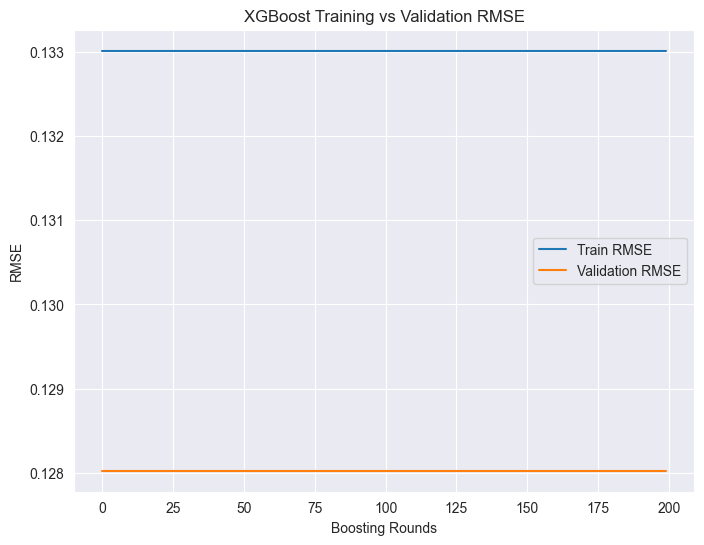

In [11]:
# Plot XGBoost RMSE
eval_results = xgb_model.evals_result()
plt.figure(figsize=(8, 6))
plt.plot(eval_results["validation_0"]["rmse"], label="Train RMSE")
plt.plot(eval_results["validation_1"]["rmse"], label="Validation RMSE")
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.title("XGBoost Training vs Validation RMSE")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# --- Physics-Informed Machine Learning (PIML) ---
class PressureDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32).to(device)
        self.targets = torch.tensor(targets, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

train_dataset = PressureDataset(X_train_scaled, y_train.values)
test_dataset = PressureDataset(X_test_scaled, y_test.values)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [13]:
# Define PyTorch model
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = RegressionModel(input_size=X_train_scaled.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [14]:
# Train PIML model
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, targets in test_loader:
            outputs = model(features)
            val_loss += criterion(outputs.squeeze(), targets).item()

    val_losses.append(val_loss / len(test_loader))
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


Epoch [1/50], Train Loss: 0.0216, Val Loss: 0.0163
Epoch [2/50], Train Loss: 0.0178, Val Loss: 0.0164
Epoch [3/50], Train Loss: 0.0178, Val Loss: 0.0164
Epoch [4/50], Train Loss: 0.0179, Val Loss: 0.0164
Epoch [5/50], Train Loss: 0.0179, Val Loss: 0.0163
Epoch [6/50], Train Loss: 0.0178, Val Loss: 0.0164
Epoch [7/50], Train Loss: 0.0178, Val Loss: 0.0165
Epoch [8/50], Train Loss: 0.0178, Val Loss: 0.0168
Epoch [9/50], Train Loss: 0.0178, Val Loss: 0.0165
Epoch [10/50], Train Loss: 0.0179, Val Loss: 0.0165
Epoch [11/50], Train Loss: 0.0179, Val Loss: 0.0165
Epoch [12/50], Train Loss: 0.0179, Val Loss: 0.0165
Epoch [13/50], Train Loss: 0.0178, Val Loss: 0.0166
Epoch [14/50], Train Loss: 0.0178, Val Loss: 0.0163
Epoch [15/50], Train Loss: 0.0179, Val Loss: 0.0163
Epoch [16/50], Train Loss: 0.0178, Val Loss: 0.0164
Epoch [17/50], Train Loss: 0.0178, Val Loss: 0.0163
Epoch [18/50], Train Loss: 0.0178, Val Loss: 0.0164
Epoch [19/50], Train Loss: 0.0178, Val Loss: 0.0166
Epoch [20/50], Train 

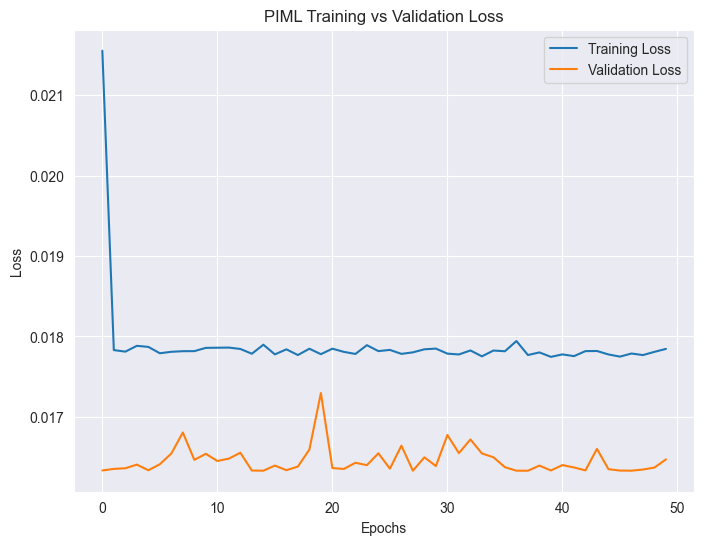

In [15]:
# Plot Training vs Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("PIML Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Evaluate PIML model
y_pred_p = []
y_true_p = []
model.eval()
with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features)
        y_pred_p.append(outputs.squeeze().cpu().numpy())
        y_true_p.append(targets.cpu().numpy())

y_pred_p = np.concatenate(y_pred_p)
y_true_p = np.concatenate(y_true_p)

mae_piml = mean_absolute_error(y_true_p, y_pred_p)
mape_piml = mean_absolute_percentage_error(y_true_p, y_pred_p)
mse_piml = mean_squared_error(y_true_p, y_pred_p)
r2_piml = r2_score(y_true_p, y_pred_p)

print(f"PIML - MAE: {mae_piml:.4f}, MAPE: {mape_piml:.4f}, MSE: {mse_piml:.4f}, R²: {r2_piml:.4f}")


PIML - MAE: 0.0972, MAPE: 0.5072, MSE: 0.0165, R²: -0.0075


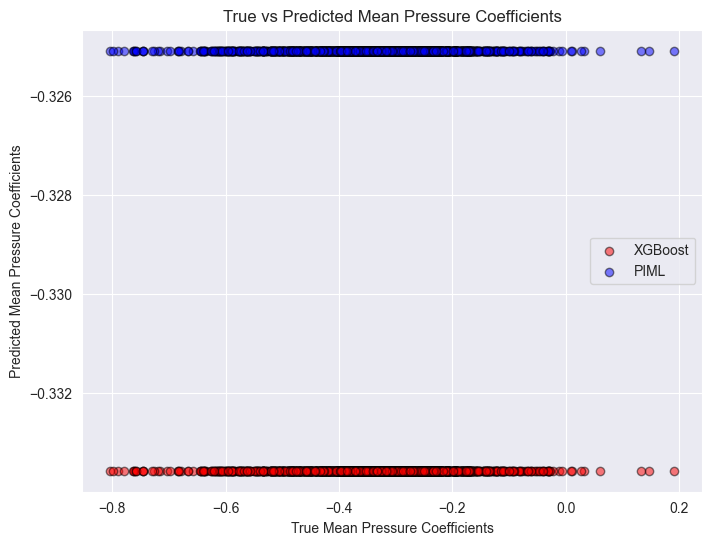

In [17]:
# --- Comparison Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='red', edgecolor='k', label='XGBoost')
plt.scatter(y_true_p, y_pred_p, alpha=0.5, color='blue', edgecolor='k', label='PIML')
plt.xlabel("True Mean Pressure Coefficients")
plt.ylabel("Predicted Mean Pressure Coefficients")
plt.title("True vs Predicted Mean Pressure Coefficients")
plt.legend()
plt.grid(True)

plt.show()